In [1]:
import os
import re
import math
import time
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report
from accelerate import Accelerator, notebook_launcher
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig, BertForSequenceClassification

# SETUP

In [2]:
warnings.filterwarnings('ignore')

In [3]:
if os.path.exists('/kaggle/working/results') == False:
    os.mkdir('/kaggle/working/results')

if os.path.exists('/kaggle/working/acquired_data') == False:
    os.mkdir('/kaggle/working/acquired_data')

In [4]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(50)

# GLOBAL VARIABLES

In [5]:
manager = Manager()

# Shared resources
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()
data_used = manager.list()
sampling_dur = manager.list()
new_samples = manager.list()
farthest_point = manager.dict()

# Non shared resources
epochs = 10
batch_size = 64
sequence_length = 80

# LOAD AND PREPROCESS DATA

In [6]:
data = pd.read_csv('/kaggle/input/multi-label-hate-speech/re_dataset.csv', encoding='latin-1')

alay_dict = pd.read_csv('/kaggle/input/multi-label-hate-speech/new_kamusalay.csv', encoding='latin-1', header=None)
alay_dict = alay_dict.rename(columns={0: 'original', 
                                      1: 'replacement'})

print("Shape: ", data.shape)
data.head()

Shape:  (13169, 13)


,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,- disaat semua cowok berusaha melacak perhatia...,1,1,1,0,0,0,0,0,1,1,0,0
1,RT USER: USER siapa yang telat ngasih tau elu?...,0,1,0,0,0,0,0,0,0,0,0,0
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",0,0,0,0,0,0,0,0,0,0,0,0
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,0,0,0,0,0,0,0,0,0,0,0,0
4,USER USER Kaum cebong kapir udah keliatan dong...,1,1,0,1,1,0,0,0,0,0,1,0


In [7]:
def lowercase(text):
    return text.lower()

def remove_unnecessary_char(text):
    text = re.sub('\n',' ',text) # Remove every '\n'
    text = re.sub('rt',' ',text) # Remove every retweet symbol
    text = re.sub('user',' ',text) # Remove every username
    text = re.sub('url', ' ', text) # Remove every URL
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text) # Remove every URL
    text = re.sub(r'\b(?:x[a-fA-F0-9]{2}\s*)+\b', '', text) # Remove emoji bytecode
    text = re.sub('  +', ' ', text) # Remove extra spaces
    return text
    
def remove_nonaplhanumeric(text):
    text = re.sub('[^0-9a-zA-Z]+', ' ', text) 
    return text

alay_dict_map = dict(zip(alay_dict['original'], alay_dict['replacement']))
def normalize_alay(text):
    return ' '.join([alay_dict_map[word] if word in alay_dict_map else word for word in text.split(' ')])

print("remove_nonaplhanumeric: ", remove_nonaplhanumeric("Halooo,,,,, duniaa \x8f \xd2\1 !!"))
print("lowercase: ", lowercase("Halooo, duniaa!"))
print("remove_unnecessary_char: ", remove_unnecessary_char("Hehe\n\n RT USER USER apa kabs www.google.com\n  hehe URL xf8 x2a x89"))
print("normalize_alay: ", normalize_alay("aamiin adek abis"))

remove_nonaplhanumeric:  Halooo duniaa 
lowercase:  halooo, duniaa!
remove_unnecessary_char:  Hehe RT USER USER apa kabs hehe URL 
normalize_alay:  amin adik habis


In [8]:
def preprocess(text):
    text = lowercase(text)
    text = remove_nonaplhanumeric(text)
    text = remove_unnecessary_char(text)
    text = normalize_alay(text) 

    return text

In [9]:
data['Tweet'] = data['Tweet'].apply(preprocess)

# Define the labels columns for multi-label classification
label_columns = data.columns[1:]  # Assuming label columns start from the third column

train_data, val_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=False)

# Extract features and labels for training and validation
X_train = train_data['Tweet'].values
y_train = train_data[label_columns].values
X_val = val_data['Tweet'].values
y_val = val_data[label_columns].values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(10535,) (10535, 12)
(2634,) (2634, 12)


# BULDING DATASET

In [10]:
class HateSpeechDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128, use_float=True):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.use_float = use_float

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['labels'] = torch.tensor(labels, dtype=torch.float if self.use_float else torch.long)
        return item

# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

In [11]:
def get_dataloaders(X_train, y_train, X_val, y_val, sequence_length=sequence_length, num_workers=4):
    train_dataset = HateSpeechDataset(X_train, y_train, tokenizer, max_length=sequence_length)
    val_dataset = HateSpeechDataset(X_val, y_val, tokenizer, max_length=sequence_length)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers
    )

    return train_loader, val_loader

In [12]:
total_data = len(X_train) + len(X_val)
initial_train_size = int(0.05 * total_data)
checkpoints = [
    int(0.5 * total_data), 
    int(0.6 * total_data), 
    int(0.7 * total_data),
    len(X_train)
]
min_increment = 200

In [13]:
def compute_metrics(p):
    preds = torch.tensor(p.predictions) # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    accuracy = (preds == labels).float().mean().item()

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    _, _, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    report = classification_report(
        labels, 
        preds, 
        target_names=['HS', 'Abusive', 'HS_Individual', 'HS_Group', 'HS_Religion', 'HS_Race', 'HS_Physical', 'HS_Gender', 'HS_Other', 'HS_Weak', 'HS_Moderate', 'HS_Strong'],
        zero_division=0
    )   
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'report': report
    }

In [14]:
def train_model(current_train_size, train_indices, metrics, trials, seed, filename):
    accelerator = Accelerator(mixed_precision='fp16')
    device = accelerator.device
    accelerator.print(accelerator.distributed_type)

    with accelerator.main_process_first():
        model = BertForSequenceClassification.from_pretrained(
            'indobenchmark/indobert-base-p1',
            num_labels=len(label_columns),
            problem_type="multi_label_classification"
        )

    # Freeze the first few layers of the encoder
    for name, param in model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    # Define DataLoaders
    current_X_train = [X_train[i] for i in train_indices]
    current_y_train = [y_train[i] for i in train_indices]
    train_loader, val_loader = get_dataloaders(current_X_train, current_y_train, X_val, y_val)

    # Define optimizer and loss function
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # Prepare everything with Accelerator
    model, optimizer, train_loader, val_loader = accelerator.prepare(
        model, optimizer, train_loader, val_loader
    )

    best_result = None
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        for batch in train_loader:
            inputs = {key: val for key, val in batch.items() if key != 'labels'}
            labels = batch['labels']

            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            optimizer.step()

            epoch_loss += loss.item()

        # Evaluation
        model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in val_loader:
                inputs = {key: val for key, val in batch.items() if key != 'labels'}
                labels = batch['labels']
                
                outputs = model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                # Gather predictions and labels from all devices
                all_preds.append(accelerator.gather(preds))
                all_labels.append(accelerator.gather(labels))

        all_preds = torch.cat(all_preds).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()

        result = compute_metrics(type('EvalOutput', (object,), {'predictions': all_preds, 'label_ids': all_labels}))

        if best_result is None or result['f1_micro'] >= best_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")

            nearest_cp = current_train_size
            if nearest_cp not in checkpoints:
                for cp in checkpoints:
                    if cp > current_train_size:
                        nearest_cp = cp
                        break
            percentage = math.ceil(nearest_cp / total_data * 100)
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(model)
            unwrapped_model.save_pretrained(
                f'{filename}-model-{percentage}',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )
            best_result = result

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")

    end_time = time.time()
    duration = end_time - start_time
    
    accelerator.print(f"\n Iteration {current_train_size}: Accuracy: {round(best_result['accuracy'], 4)}, F1 Micro: {round(best_result['f1_micro'], 4)}, F1 Macro: {round(best_result['f1_macro'], 4)}")
    accelerator.print(best_result['report'])
    accelerator.print(f"Training completed in {duration} s")

    # Update the shared lists
    if accelerator.is_local_main_process:
        metrics[0].append(current_train_size)
        metrics[1].append(best_result['accuracy'])
        metrics[2].append(best_result['f1_micro'])
        metrics[3].append(best_result['f1_macro'])

In [15]:
import matplotlib.pyplot as plt

def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

In [ ]:
def combined_sampling(model, farthest_point, X_pool, train_indices, remaining_indices, tokenizer, sampling_dur, new_samples, trials, filename):
    accelerator = Accelerator(mixed_precision="fp16")
    device = accelerator.device
    model.to(device)
    
    current_train_size = len(train_indices)
    
    # Check nearest checkpoint
    nearest_cp = 0
    for cp in checkpoints:
        if cp > current_train_size:
            nearest_cp = cp
            break

    target_samples = math.ceil(0.1*len(remaining_indices))
    if target_samples <= min_increment and min_increment < nearest_cp - current_train_size:
        target_samples = min_increment
    elif target_samples > min_increment and target_samples < nearest_cp - current_train_size:
        target_samples = target_samples
    else:
        target_samples = nearest_cp - current_train_size

    final_cp = False
    # No sampling needed when there's little data left or we've reached the last checkpoint
    if current_train_size >= checkpoints[-1] - target_samples:
        final_cp = True

        if accelerator.is_main_process:
            temp = train_indices.copy()
            temp.extend(remaining_indices)
            
            # Save acquired data up to checkpoint
            acquired_data = pd.DataFrame({
                'processed_text': [X_train[i] for i in temp],
                'HS': [y_train[i][0] for i in temp],
                'Abusive': [y_train[i][1] for i in temp],
                'HS_Individual': [y_train[i][2] for i in temp],
                'HS_Group': [y_train[i][3] for i in temp],
                'HS_Religion': [y_train[i][4] for i in temp],
                'HS_Race': [y_train[i][5] for i in temp],
                'HS_Physical': [y_train[i][6] for i in temp],
                'HS_Gender': [y_train[i][7] for i in temp],
                'HS_Other': [y_train[i][8] for i in temp],
                'HS_Weak': [y_train[i][9] for i in temp],
                'HS_Moderate': [y_train[i][10] for i in temp],
                'HS_Strong': [y_train[i][11] for i in temp],
            })
            acquired_data.to_csv(f'acquired_data/{filename}-data-{nearest_cp}.csv', index=False)
            
            print("Nearest checkpoint:", nearest_cp)
            print("Acquired samples:", len(remaining_indices))
            
            sampling_dur.append(0)
            for i in remaining_indices:
                new_samples.append(i)

    accelerator.wait_for_everyone()
    if not final_cp:
        # Create dataset and dataloader for both methods
        dataset = HateSpeechDataset(X_pool, np.zeros((len(X_pool), 4)), tokenizer, max_length=sequence_length)
        dataloader = DataLoader(
            dataset,
            batch_size=batch_size,
            num_workers=4,
            pin_memory=True,
        )
        
        # Start timing
        start_time = time.time()
        
        # Get Coreset samples
        coreset_samples = get_coreset_samples(model, farthest_point, dataloader, dataset, device, target_samples)
        coreset_samples = [remaining_indices[i] for i in coreset_samples]
        accelerator.print(f"Got {len(coreset_samples)} samples from coreset")
        
        # Get Monte Carlo samples
        mc_indices = get_monte_carlo_samples(model, dataloader, device, target_samples)
        mc_indices = [remaining_indices[i] for i in mc_indices]
        accelerator.print(f"Got {len(mc_indices)} samples from mc")
    
        if accelerator.is_main_process:
            # Combine both methods' results
            combined_indices = list(set(coreset_samples).union(set(mc_indices)))
            
            # If we got more than we need, take only what we need
            if len(combined_indices) > target_samples:
                np.random.shuffle(combined_indices)
                combined_indices = combined_indices[:target_samples]
            
            # Calculate duration
            end_time = time.time()
            duration = end_time - start_time
            
            # Check if we've reached a checkpoint
            if current_train_size + len(combined_indices) >= nearest_cp:
                temp = train_indices.copy()
                temp.extend(combined_indices)
                
                # Save acquired data up to checkpoint
                acquired_data = pd.DataFrame({
                    'processed_text': [X_train[i] for i in temp],
                    'HS': [y_train[i][0] for i in temp],
                    'Abusive': [y_train[i][1] for i in temp],
                    'HS_Individual': [y_train[i][2] for i in temp],
                    'HS_Group': [y_train[i][3] for i in temp],
                    'HS_Religion': [y_train[i][4] for i in temp],
                    'HS_Race': [y_train[i][5] for i in temp],
                    'HS_Physical': [y_train[i][6] for i in temp],
                    'HS_Gender': [y_train[i][7] for i in temp],
                    'HS_Other': [y_train[i][8] for i in temp],
                    'HS_Weak': [y_train[i][9] for i in temp],
                    'HS_Moderate': [y_train[i][10] for i in temp],
                    'HS_Strong': [y_train[i][11] for i in temp],
                })
                acquired_data.to_csv(f'acquired_data/{filename}-data-{nearest_cp}.csv', index=False)
            
            # Log results
            print("Nearest checkpoint:", nearest_cp)
            print(f"Acquired samples: {len(combined_indices)}")
            print(f"Sampling duration: {duration} seconds")
            
            sampling_dur.append(duration)
            for i in combined_indices:
                new_samples.append(i)

def get_coreset_samples(model, farthest_point, dataloader, dataset, device, n_samples, n_clusters=min_increment):
    model.eval()
    embeddings = []
    farthest_data = dict(farthest_point)
    
    # Get embeddings
    with torch.no_grad():
        for data in dataloader:
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_mask'].to(device)
            outputs = model.base_model(input_ids=input_ids, attention_mask=attention_mask)
            hidden_states = outputs.last_hidden_state.mean(dim=1)  # Mean of hidden states for vector representation
            embeddings.append(hidden_states.cpu().numpy())

    if 'input_ids' in farthest_data:
        with torch.no_grad():
            outputs = model.base_model(
                input_ids=farthest_data['input_ids'].unsqueeze(0).to(device, non_blocking=True), 
                attention_mask=farthest_data['attention_mask'].unsqueeze(0).to(device, non_blocking=True)
            )
            hidden_states = outputs.last_hidden_state.mean(dim=1)  # Mean of hidden states for vector representation
            embeddings.append(hidden_states.cpu().numpy())
    
    # Convert embeddings list to numpy array
    embeddings = np.vstack(embeddings)
    embeddings = np.array(embeddings)

    distance_matrix = pairwise_distances(embeddings)    
    selected_indices = distance_matrix.shape[0] - 1 if 'input_ids' in farthest_data else 0
    
    min_distances = distance_matrix[selected_indices]
    sorted_dist = np.argsort(min_distances)
    sorted_dist = sorted_dist[::-1]
    farthest_point['input_ids'] = dataset[sorted_dist[0]]['input_ids']
    farthest_point['attention_mask'] = dataset[sorted_dist[0]]['attention_mask']

    threshold = np.percentile(min_distances, 90)
    candidates = np.where(min_distances >= threshold)[0]  # Select the point farthest from the current set
    num_of_candidates = len(candidates)

    return sorted_dist[:n_samples]

def get_monte_carlo_samples(model, dataloader, device, n_samples):
    model.train()

    confidences = []
    # Calculate uncertainties
    for data in dataloader:
        batch_probs = []
        input_ids = data['input_ids'].to(device, non_blocking=True)
        attention_mask = data['attention_mask'].to(device, non_blocking=True)

        for _ in range(3):
            with torch.no_grad():
                outputs = model(input_ids=input_ids, attention_mask=attention_mask).logits
            probs = torch.sigmoid(outputs).cpu().numpy()  # Shape: (batch_size, num_classes)
            batch_probs.append(probs)

        # Stack the probabilities from multiple MC passes
        batch_probs = np.stack(batch_probs, axis=0)  # Shape: (mc_passes, batch_size, num_classes)

        # Calculate mean probability and uncertainty for each sample in the batch
        mean_probs = np.mean(batch_probs, axis=0)  # Shape: (batch_size, num_classes)
        uncertainties = np.mean(np.var(batch_probs, axis=0), axis=1)  # Shape: (batch_size,)

        # Append the uncertainties to the confidences list
        confidences.extend(uncertainties)
    
    uncertainties = np.array(confidences)
    sorted_unc = np.argsort(confidences)
    sorted_unc = sorted_unc[::-1]  # Reverse to get highest uncertainty first

    threshold = np.percentile(confidences, 90)
    items_greater_than_average = uncertainties[confidences >= threshold]
    least_confident_indices = sorted_unc[:n_samples]

    return least_confident_indices

In [17]:
def active_learning(seed, i):
    accuracies = manager.list()
    f1_micros = manager.list()
    f1_macros = manager.list()
    data_used = manager.list()
    sampling_dur = manager.list()
    new_samples = manager.list()
    farthest_point = manager.dict()
    filename = 'hsd-mc-coreset'

    set_seed(seed)
    
    print("===============================================")
    print("TRIAL {}".format(i+1))
    print("Random seed:", seed)
    
    train_indices = np.random.choice(range(len(X_train)), initial_train_size, replace=False).tolist()
    remaining_indices = list(set(range(len(X_train))) - set(train_indices))
    
    current_train_size = initial_train_size
    
    start_time = time.time()
    while current_train_size < checkpoints[len(checkpoints) - 1]:
        # Train the model
        args = (current_train_size, train_indices, (data_used, accuracies, f1_micros, f1_macros), i, seed, filename)
        notebook_launcher(train_model, args, num_processes=2)

        nearest_cp = current_train_size
        if nearest_cp not in checkpoints:
            for cp in checkpoints:
                if cp > current_train_size:
                    nearest_cp = cp
                    break
        percentage = math.ceil(nearest_cp / total_data * 100)
        
        model = BertForSequenceClassification.from_pretrained(f'{filename}-model-{percentage}')
    
        # Perform query strategy to select new samples
        new_samples = manager.list()
        sampling_args = (model, farthest_point, [X_train[i] for i in remaining_indices], train_indices, remaining_indices, tokenizer, sampling_dur, new_samples, i, filename)
        notebook_launcher(combined_sampling, sampling_args, num_processes=2)
        new_samples = list(new_samples)
        train_indices.extend(new_samples)
        remaining_indices = list(set(remaining_indices) - set(new_samples))
    
        # Update current training size
        current_train_size = len(train_indices)
        print("New train size: {}".format(current_train_size))
    
    # Train last epoch
    args = (current_train_size, train_indices, (data_used, accuracies, f1_micros, f1_macros), i, seed, filename)
    notebook_launcher(train_model, args, num_processes=2)
    data_used, accuracies, f1_micros, f1_macros, sampling_dur = list(data_used), list(accuracies), list(f1_micros), list(f1_macros), list(sampling_dur)
    
    end_time = time.time()
    duration = end_time - start_time
    
    print(f"Total sampling time: {np.array(sampling_dur).sum().round(2)} seconds")
    print(f"Total runtime: {duration} seconds")
    
    plot_result(data_used, accuracies, f1_micros, f1_macros)
    
    results = pd.DataFrame({
        'Data Used': data_used,
        'Accuracy': accuracies,
        'F1 Micro': f1_micros,
        'F1 Macro': f1_macros,
    })
    
    sampling_dur.insert(0, 0)
    results['Sampling Duration'] = sampling_dur
    results.to_csv(f'results/{filename}-results.csv', index=False)

In [18]:
seeds = [50, 81, 14, 3, 94]

TRIAL 1
Random seed: 50
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6065, Accuracy: 0.8198, F1 Micro: 0.122, F1 Macro: 0.0444
Epoch 2/10, Train Loss: 0.4617, Accuracy: 0.8278, F1 Micro: 0.0007, F1 Macro: 0.0003
Epoch 3/10, Train Loss: 0.3954, Accuracy: 0.8278, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 4/10, Train Loss: 0.3949, Accuracy: 0.8281, F1 Micro: 0.0036, F1 Macro: 0.0016
Epoch 5/10, Train Loss: 0.3769, Accuracy: 0.8324, F1 Micro: 0.0595, F1 Macro: 0.0247
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3696, Accuracy: 0.8475, F1 Micro: 0.2419, F1 Macro: 0.0856
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3475, Accuracy: 0.8544, F1 Micro: 0.3196, F1 Macro: 0.1086
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3336, Accuracy: 0.8698, F1 Micro: 0.4829, F1 Macro: 0.2106
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.2992, Accuracy: 0.8751, F1 Micro: 0.5435, F1 Macro: 0.2653
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.2712, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5324, Accuracy: 0.8344, F1 Micro: 0.1529, F1 Macro: 0.0426
Epoch 2/10, Train Loss: 0.3988, Accuracy: 0.8373, F1 Micro: 0.1365, F1 Macro: 0.0465
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3689, Accuracy: 0.8589, F1 Micro: 0.4457, F1 Macro: 0.1737
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3409, Accuracy: 0.8784, F1 Micro: 0.5736, F1 Macro: 0.2866
Epoch 5/10, Train Loss: 0.2979, Accuracy: 0.8809, F1 Micro: 0.5588, F1 Macro: 0.303
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2587, Accuracy: 0.8873, F1 Micro: 0.6546, F1 Macro: 0.4488
Epoch 7/10, Train Loss: 0.2287, Accuracy: 0.891, F1 Micro: 0.6293, F1 Macro: 0.4422
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.211, Accuracy: 0.8905, F1 Micro: 0.6827, F1 Macro: 0.5109
Epoch 9/10, Train Loss: 0.1823, Accuracy: 0.8937, F1 Micro: 0.6356, F1 Macro: 0.4563
Epoch 10/10, Train Loss: 0.1729, Accuracy: 0.8968, F1 Micro: 0.6753, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5045, Accuracy: 0.8387, F1 Micro: 0.4091, F1 Macro: 0.1128
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3931, Accuracy: 0.8543, F1 Micro: 0.46, F1 Macro: 0.2012
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3461, Accuracy: 0.8812, F1 Micro: 0.5688, F1 Macro: 0.2776
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3035, Accuracy: 0.8891, F1 Micro: 0.6238, F1 Macro: 0.3788
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2723, Accuracy: 0.8956, F1 Micro: 0.6729, F1 Macro: 0.4354
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2334, Accuracy: 0.8993, F1 Micro: 0.6762, F1 Macro: 0.4795
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2059, Accuracy: 0.901, F1 Micro: 0.6967, F1 Macro: 0.5172
Epoch 8/10, Train Loss: 0.181, Accuracy: 0.9016, F1 Micro: 0.6815, F1 Macro: 0.4926
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.153, Accuracy: 0.9044, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4783, Accuracy: 0.8436, F1 Micro: 0.408, F1 Macro: 0.1183
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3753, Accuracy: 0.8794, F1 Micro: 0.5757, F1 Macro: 0.2796
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3166, Accuracy: 0.8909, F1 Micro: 0.6273, F1 Macro: 0.3687
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2749, Accuracy: 0.901, F1 Micro: 0.6985, F1 Macro: 0.5054
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.228, Accuracy: 0.9044, F1 Micro: 0.6989, F1 Macro: 0.5011
Epoch 6/10, Train Loss: 0.1958, Accuracy: 0.9044, F1 Micro: 0.6911, F1 Macro: 0.5395
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1743, Accuracy: 0.9085, F1 Micro: 0.7196, F1 Macro: 0.5652
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1461, Accuracy: 0.9085, F1 Micro: 0.7295, F1 Macro: 0.5837
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1254, Accuracy: 0.909, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4711, Accuracy: 0.8486, F1 Micro: 0.4335, F1 Macro: 0.1623
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3609, Accuracy: 0.8848, F1 Micro: 0.6142, F1 Macro: 0.3107
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3075, Accuracy: 0.8955, F1 Micro: 0.6397, F1 Macro: 0.3868
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2637, Accuracy: 0.901, F1 Micro: 0.7068, F1 Macro: 0.5131
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2263, Accuracy: 0.9, F1 Micro: 0.7234, F1 Macro: 0.5598
Epoch 6/10, Train Loss: 0.1976, Accuracy: 0.9098, F1 Micro: 0.7106, F1 Macro: 0.5318
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1682, Accuracy: 0.9102, F1 Micro: 0.7396, F1 Macro: 0.6085
Epoch 8/10, Train Loss: 0.1386, Accuracy: 0.9111, F1 Micro: 0.7304, F1 Macro: 0.6133
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.124, Accuracy: 0.9122, F1 Micro: 0.7463, F1 Macro: 0.6489
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4647, Accuracy: 0.8499, F1 Micro: 0.4902, F1 Macro: 0.2007
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3486, Accuracy: 0.8896, F1 Micro: 0.6299, F1 Macro: 0.3472
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.289, Accuracy: 0.9001, F1 Micro: 0.6811, F1 Macro: 0.4869
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2495, Accuracy: 0.9068, F1 Micro: 0.7169, F1 Macro: 0.5611
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2075, Accuracy: 0.9058, F1 Micro: 0.7272, F1 Macro: 0.572
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.181, Accuracy: 0.9065, F1 Micro: 0.7288, F1 Macro: 0.5776
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1487, Accuracy: 0.9153, F1 Micro: 0.7431, F1 Macro: 0.6152
Epoch 8/10, Train Loss: 0.1298, Accuracy: 0.9135, F1 Micro: 0.7389, F1 Macro: 0.6193
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1136, Accuracy: 0.9158, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4526, Accuracy: 0.8559, F1 Micro: 0.4867, F1 Macro: 0.2039
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3416, Accuracy: 0.8938, F1 Micro: 0.649, F1 Macro: 0.3534
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2784, Accuracy: 0.9042, F1 Micro: 0.6944, F1 Macro: 0.5089
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2398, Accuracy: 0.909, F1 Micro: 0.725, F1 Macro: 0.5571
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1986, Accuracy: 0.9104, F1 Micro: 0.7399, F1 Macro: 0.5854
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1699, Accuracy: 0.916, F1 Micro: 0.7438, F1 Macro: 0.5961
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1453, Accuracy: 0.9179, F1 Micro: 0.7529, F1 Macro: 0.6264
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1214, Accuracy: 0.9158, F1 Micro: 0.7567, F1 Macro: 0.658
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4486, Accuracy: 0.8682, F1 Micro: 0.5217, F1 Macro: 0.229
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3318, Accuracy: 0.8963, F1 Micro: 0.6718, F1 Macro: 0.4351
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2686, Accuracy: 0.9054, F1 Micro: 0.7215, F1 Macro: 0.5247
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2301, Accuracy: 0.9107, F1 Micro: 0.7396, F1 Macro: 0.567
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1936, Accuracy: 0.9123, F1 Micro: 0.7479, F1 Macro: 0.6002
Epoch 6/10, Train Loss: 0.1654, Accuracy: 0.9139, F1 Micro: 0.7476, F1 Macro: 0.6033
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1402, Accuracy: 0.9148, F1 Micro: 0.7512, F1 Macro: 0.6394
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1199, Accuracy: 0.9162, F1 Micro: 0.7541, F1 Macro: 0.6472
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1001, Accuracy: 0.9199, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4434, Accuracy: 0.8735, F1 Micro: 0.5846, F1 Macro: 0.2716
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3286, Accuracy: 0.8978, F1 Micro: 0.6574, F1 Macro: 0.4273
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2697, Accuracy: 0.9089, F1 Micro: 0.7102, F1 Macro: 0.5487
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2214, Accuracy: 0.914, F1 Micro: 0.7298, F1 Macro: 0.5442
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1854, Accuracy: 0.9137, F1 Micro: 0.7404, F1 Macro: 0.5992
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1573, Accuracy: 0.9186, F1 Micro: 0.7566, F1 Macro: 0.6289
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1311, Accuracy: 0.9206, F1 Micro: 0.7583, F1 Macro: 0.6487
Epoch 8/10, Train Loss: 0.1111, Accuracy: 0.9209, F1 Micro: 0.7561, F1 Macro: 0.6437
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1003, Accuracy: 0.9221, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4404, Accuracy: 0.8776, F1 Micro: 0.5849, F1 Macro: 0.2709
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3239, Accuracy: 0.8989, F1 Micro: 0.7027, F1 Macro: 0.5069
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2573, Accuracy: 0.9081, F1 Micro: 0.7255, F1 Macro: 0.5556
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2186, Accuracy: 0.9149, F1 Micro: 0.7463, F1 Macro: 0.5857
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1835, Accuracy: 0.9139, F1 Micro: 0.753, F1 Macro: 0.6255
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1531, Accuracy: 0.9142, F1 Micro: 0.7587, F1 Macro: 0.655
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1307, Accuracy: 0.9204, F1 Micro: 0.7629, F1 Macro: 0.6571
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1115, Accuracy: 0.9223, F1 Micro: 0.7683, F1 Macro: 0.6624
Epoch 9/10, Train Loss: 0.0938, Accuracy: 0.9202, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4383, Accuracy: 0.882, F1 Micro: 0.588, F1 Macro: 0.2783
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3132, Accuracy: 0.9006, F1 Micro: 0.7013, F1 Macro: 0.5002
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2539, Accuracy: 0.9094, F1 Micro: 0.7292, F1 Macro: 0.5551
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2128, Accuracy: 0.9157, F1 Micro: 0.7425, F1 Macro: 0.5949
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1763, Accuracy: 0.9179, F1 Micro: 0.7603, F1 Macro: 0.6497
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1481, Accuracy: 0.9142, F1 Micro: 0.761, F1 Macro: 0.6535
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1255, Accuracy: 0.9228, F1 Micro: 0.7655, F1 Macro: 0.6474
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1078, Accuracy: 0.9209, F1 Micro: 0.768, F1 Macro: 0.6564
Epoch 9/10, Train Loss: 0.0922, Accuracy: 0.9192, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4328, Accuracy: 0.8802, F1 Micro: 0.6254, F1 Macro: 0.304
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3032, Accuracy: 0.9016, F1 Micro: 0.6778, F1 Macro: 0.4796
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2459, Accuracy: 0.912, F1 Micro: 0.7133, F1 Macro: 0.5536
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2063, Accuracy: 0.9164, F1 Micro: 0.7511, F1 Macro: 0.6047
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1756, Accuracy: 0.9184, F1 Micro: 0.7606, F1 Macro: 0.6367
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.151, Accuracy: 0.9191, F1 Micro: 0.7643, F1 Macro: 0.6339
Epoch 7/10, Train Loss: 0.1235, Accuracy: 0.9212, F1 Micro: 0.7546, F1 Macro: 0.6604
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1067, Accuracy: 0.9226, F1 Micro: 0.7729, F1 Macro: 0.6786
Epoch 9/10, Train Loss: 0.093, Accuracy: 0.9211, F1 Micro: 0.7676, F1 Macro: 0.6701
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4253, Accuracy: 0.8831, F1 Micro: 0.598, F1 Macro: 0.2886
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3038, Accuracy: 0.9043, F1 Micro: 0.7095, F1 Macro: 0.4947
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.246, Accuracy: 0.9122, F1 Micro: 0.7374, F1 Macro: 0.5602
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2031, Accuracy: 0.9139, F1 Micro: 0.7511, F1 Macro: 0.6113
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1684, Accuracy: 0.9204, F1 Micro: 0.7654, F1 Macro: 0.6459
Epoch 6/10, Train Loss: 0.1423, Accuracy: 0.9218, F1 Micro: 0.7641, F1 Macro: 0.6559
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1184, Accuracy: 0.9231, F1 Micro: 0.7681, F1 Macro: 0.656
Epoch 8/10, Train Loss: 0.1023, Accuracy: 0.9238, F1 Micro: 0.7671, F1 Macro: 0.6826
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0909, Accuracy: 0.9244, F1 Micro: 0.7718, F1 Macro: 0.6961
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4228, Accuracy: 0.8835, F1 Micro: 0.6178, F1 Macro: 0.3026
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3011, Accuracy: 0.9045, F1 Micro: 0.6931, F1 Macro: 0.4895
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2407, Accuracy: 0.9125, F1 Micro: 0.7375, F1 Macro: 0.5727
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2024, Accuracy: 0.9185, F1 Micro: 0.7558, F1 Macro: 0.6037
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1653, Accuracy: 0.9221, F1 Micro: 0.7669, F1 Macro: 0.6318
Epoch 6/10, Train Loss: 0.1426, Accuracy: 0.9207, F1 Micro: 0.7661, F1 Macro: 0.659
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1263, Accuracy: 0.9216, F1 Micro: 0.7695, F1 Macro: 0.6781
Epoch 8/10, Train Loss: 0.1026, Accuracy: 0.9213, F1 Micro: 0.7688, F1 Macro: 0.6745
Epoch 9/10, Train Loss: 0.0889, Accuracy: 0.9193, F1 Micro: 0.769, F1 Macro: 0.6854
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4217, Accuracy: 0.8843, F1 Micro: 0.5899, F1 Macro: 0.2811
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2934, Accuracy: 0.9055, F1 Micro: 0.6916, F1 Macro: 0.5024
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2429, Accuracy: 0.9132, F1 Micro: 0.7186, F1 Macro: 0.5603
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2022, Accuracy: 0.92, F1 Micro: 0.7496, F1 Macro: 0.6062
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1706, Accuracy: 0.9186, F1 Micro: 0.7652, F1 Macro: 0.6321
Epoch 6/10, Train Loss: 0.1392, Accuracy: 0.9221, F1 Micro: 0.7632, F1 Macro: 0.6424
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1172, Accuracy: 0.9233, F1 Micro: 0.7743, F1 Macro: 0.6758
Epoch 8/10, Train Loss: 0.1024, Accuracy: 0.9258, F1 Micro: 0.7729, F1 Macro: 0.679
Epoch 9/10, Train Loss: 0.0911, Accuracy: 0.921, F1 Micro: 0.7715, F1 Macro: 0.6926
Epoch 10/10, Train Loss: 0.0764, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4176, Accuracy: 0.8843, F1 Micro: 0.6006, F1 Macro: 0.2904
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2906, Accuracy: 0.903, F1 Micro: 0.7116, F1 Macro: 0.5004
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2389, Accuracy: 0.9162, F1 Micro: 0.7434, F1 Macro: 0.5937
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.194, Accuracy: 0.9185, F1 Micro: 0.7593, F1 Macro: 0.6184
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1684, Accuracy: 0.9234, F1 Micro: 0.7615, F1 Macro: 0.6308
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.139, Accuracy: 0.9248, F1 Micro: 0.7623, F1 Macro: 0.6462
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1161, Accuracy: 0.9212, F1 Micro: 0.7722, F1 Macro: 0.6715
Epoch 8/10, Train Loss: 0.0997, Accuracy: 0.922, F1 Micro: 0.7701, F1 Macro: 0.6888
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0854, Accuracy: 0.924, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4119, Accuracy: 0.8833, F1 Micro: 0.5742, F1 Macro: 0.2899
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2854, Accuracy: 0.9051, F1 Micro: 0.6836, F1 Macro: 0.4883
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2313, Accuracy: 0.9133, F1 Micro: 0.7297, F1 Macro: 0.5305
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.189, Accuracy: 0.9195, F1 Micro: 0.762, F1 Macro: 0.6224
Epoch 5/10, Train Loss: 0.1623, Accuracy: 0.9224, F1 Micro: 0.759, F1 Macro: 0.6288
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1337, Accuracy: 0.9243, F1 Micro: 0.7768, F1 Macro: 0.6822
Epoch 7/10, Train Loss: 0.1173, Accuracy: 0.9218, F1 Micro: 0.7721, F1 Macro: 0.674
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0974, Accuracy: 0.924, F1 Micro: 0.7772, F1 Macro: 0.6864
Epoch 9/10, Train Loss: 0.0828, Accuracy: 0.9197, F1 Micro: 0.7718, F1 Macro: 0.6862
Epoch 10/10, Train Loss: 0.0728, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4088, Accuracy: 0.8851, F1 Micro: 0.6421, F1 Macro: 0.3236
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2804, Accuracy: 0.9046, F1 Micro: 0.7136, F1 Macro: 0.5328
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2288, Accuracy: 0.9159, F1 Micro: 0.7395, F1 Macro: 0.577
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1948, Accuracy: 0.9192, F1 Micro: 0.7587, F1 Macro: 0.6171
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1618, Accuracy: 0.9223, F1 Micro: 0.7651, F1 Macro: 0.6491
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1351, Accuracy: 0.9211, F1 Micro: 0.7709, F1 Macro: 0.6534
Epoch 7/10, Train Loss: 0.1155, Accuracy: 0.9235, F1 Micro: 0.7654, F1 Macro: 0.6631
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0993, Accuracy: 0.9246, F1 Micro: 0.773, F1 Macro: 0.673
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0861, Accuracy: 0.9227, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.402, Accuracy: 0.885, F1 Micro: 0.6342, F1 Macro: 0.3135
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2805, Accuracy: 0.906, F1 Micro: 0.6905, F1 Macro: 0.4904
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2291, Accuracy: 0.9148, F1 Micro: 0.7432, F1 Macro: 0.5852
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1881, Accuracy: 0.9217, F1 Micro: 0.7608, F1 Macro: 0.6154
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1574, Accuracy: 0.9236, F1 Micro: 0.7694, F1 Macro: 0.6609
Epoch 6/10, Train Loss: 0.1324, Accuracy: 0.9235, F1 Micro: 0.7682, F1 Macro: 0.6667
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1125, Accuracy: 0.9223, F1 Micro: 0.7776, F1 Macro: 0.6872
Epoch 8/10, Train Loss: 0.0939, Accuracy: 0.924, F1 Micro: 0.7721, F1 Macro: 0.6866
Epoch 9/10, Train Loss: 0.081, Accuracy: 0.9245, F1 Micro: 0.7745, F1 Macro: 0.688
Epoch 10/10, Train Loss: 0.0694, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4045, Accuracy: 0.8858, F1 Micro: 0.616, F1 Macro: 0.3035
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2793, Accuracy: 0.9063, F1 Micro: 0.7046, F1 Macro: 0.5075
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2239, Accuracy: 0.9153, F1 Micro: 0.7427, F1 Macro: 0.5791
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1874, Accuracy: 0.9155, F1 Micro: 0.7609, F1 Macro: 0.6218
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.157, Accuracy: 0.9245, F1 Micro: 0.7711, F1 Macro: 0.6455
Epoch 6/10, Train Loss: 0.1319, Accuracy: 0.9222, F1 Micro: 0.768, F1 Macro: 0.6652
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1108, Accuracy: 0.9233, F1 Micro: 0.7783, F1 Macro: 0.6829
Epoch 8/10, Train Loss: 0.0972, Accuracy: 0.9236, F1 Micro: 0.7763, F1 Macro: 0.6869
Epoch 9/10, Train Loss: 0.0818, Accuracy: 0.9236, F1 Micro: 0.7774, F1 Macro: 0.694
Epoch 10/10, Train Loss: 0.0725, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.405, Accuracy: 0.8857, F1 Micro: 0.6067, F1 Macro: 0.3049
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2736, Accuracy: 0.9077, F1 Micro: 0.7125, F1 Macro: 0.5252
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2276, Accuracy: 0.9151, F1 Micro: 0.7282, F1 Macro: 0.5454
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1897, Accuracy: 0.9216, F1 Micro: 0.7586, F1 Macro: 0.61
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1572, Accuracy: 0.9219, F1 Micro: 0.7602, F1 Macro: 0.6326
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1321, Accuracy: 0.9197, F1 Micro: 0.7717, F1 Macro: 0.6721
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1115, Accuracy: 0.9234, F1 Micro: 0.7765, F1 Macro: 0.6945
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0956, Accuracy: 0.921, F1 Micro: 0.7766, F1 Macro: 0.6882
Epoch 9/10, Train Loss: 0.0814, Accuracy: 0.924, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3962, Accuracy: 0.8861, F1 Micro: 0.6431, F1 Macro: 0.3353
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2717, Accuracy: 0.9064, F1 Micro: 0.693, F1 Macro: 0.5053
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2223, Accuracy: 0.9147, F1 Micro: 0.7464, F1 Macro: 0.5729
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1824, Accuracy: 0.9197, F1 Micro: 0.7607, F1 Macro: 0.6241
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.154, Accuracy: 0.9243, F1 Micro: 0.7728, F1 Macro: 0.6488
Epoch 6/10, Train Loss: 0.1281, Accuracy: 0.9209, F1 Micro: 0.771, F1 Macro: 0.6543
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1083, Accuracy: 0.9267, F1 Micro: 0.7795, F1 Macro: 0.6714
Epoch 8/10, Train Loss: 0.0937, Accuracy: 0.9228, F1 Micro: 0.776, F1 Macro: 0.6829
Epoch 9/10, Train Loss: 0.0822, Accuracy: 0.9244, F1 Micro: 0.7741, F1 Macro: 0.6995
Epoch 10/10, Train Loss: 0.0703, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3939, Accuracy: 0.8862, F1 Micro: 0.627, F1 Macro: 0.3168
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2752, Accuracy: 0.9065, F1 Micro: 0.7037, F1 Macro: 0.5204
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2119, Accuracy: 0.9167, F1 Micro: 0.7452, F1 Macro: 0.5799
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1805, Accuracy: 0.9184, F1 Micro: 0.7605, F1 Macro: 0.6164
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1553, Accuracy: 0.9169, F1 Micro: 0.7667, F1 Macro: 0.649
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1257, Accuracy: 0.9231, F1 Micro: 0.7746, F1 Macro: 0.6642
Epoch 7/10, Train Loss: 0.1101, Accuracy: 0.9229, F1 Micro: 0.7738, F1 Macro: 0.6836
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0902, Accuracy: 0.9255, F1 Micro: 0.78, F1 Macro: 0.6856
Epoch 9/10, Train Loss: 0.0743, Accuracy: 0.9204, F1 Micro: 0.7752, F1 Macro: 0.6943
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3896, Accuracy: 0.8868, F1 Micro: 0.6026, F1 Macro: 0.3028
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2622, Accuracy: 0.9071, F1 Micro: 0.6973, F1 Macro: 0.5096
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2163, Accuracy: 0.9146, F1 Micro: 0.7258, F1 Macro: 0.5578
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1813, Accuracy: 0.9195, F1 Micro: 0.7632, F1 Macro: 0.6125
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1513, Accuracy: 0.9209, F1 Micro: 0.7655, F1 Macro: 0.6506
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1252, Accuracy: 0.9222, F1 Micro: 0.7755, F1 Macro: 0.656
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1066, Accuracy: 0.9251, F1 Micro: 0.777, F1 Macro: 0.6841
Epoch 8/10, Train Loss: 0.0881, Accuracy: 0.9226, F1 Micro: 0.7734, F1 Macro: 0.6888
Epoch 9/10, Train Loss: 0.0751, Accuracy: 0.9242, F1 Micro: 0.7737, F1 Macro: 0.6868
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3827, Accuracy: 0.8871, F1 Micro: 0.6024, F1 Macro: 0.301
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2571, Accuracy: 0.9088, F1 Micro: 0.7164, F1 Macro: 0.5269
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2118, Accuracy: 0.9139, F1 Micro: 0.7513, F1 Macro: 0.5958
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1757, Accuracy: 0.9225, F1 Micro: 0.7649, F1 Macro: 0.616
Epoch 5/10, Train Loss: 0.1447, Accuracy: 0.9183, F1 Micro: 0.7648, F1 Macro: 0.6311
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1193, Accuracy: 0.924, F1 Micro: 0.7763, F1 Macro: 0.6676
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1058, Accuracy: 0.9253, F1 Micro: 0.777, F1 Macro: 0.6805
Epoch 8/10, Train Loss: 0.0905, Accuracy: 0.9185, F1 Micro: 0.7701, F1 Macro: 0.6961
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.074, Accuracy: 0.9238, F1 Micro: 0.7778, F1 Macro: 0.697
Higher F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3771, Accuracy: 0.8876, F1 Micro: 0.6019, F1 Macro: 0.3033
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2549, Accuracy: 0.9084, F1 Micro: 0.706, F1 Macro: 0.5066
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2071, Accuracy: 0.9153, F1 Micro: 0.7508, F1 Macro: 0.5873
Epoch 4/10, Train Loss: 0.1758, Accuracy: 0.9205, F1 Micro: 0.7463, F1 Macro: 0.5904
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1471, Accuracy: 0.9217, F1 Micro: 0.7681, F1 Macro: 0.6395
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1209, Accuracy: 0.9249, F1 Micro: 0.7756, F1 Macro: 0.6672
Epoch 7/10, Train Loss: 0.102, Accuracy: 0.9215, F1 Micro: 0.7729, F1 Macro: 0.676
Epoch 8/10, Train Loss: 0.0865, Accuracy: 0.9238, F1 Micro: 0.7696, F1 Macro: 0.6926
Epoch 9/10, Train Loss: 0.0737, Accuracy: 0.9223, F1 Micro: 0.775, F1 Macro: 0.698
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0639, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3801, Accuracy: 0.8895, F1 Micro: 0.6343, F1 Macro: 0.3436
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2499, Accuracy: 0.9073, F1 Micro: 0.7253, F1 Macro: 0.5383
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2027, Accuracy: 0.915, F1 Micro: 0.733, F1 Macro: 0.5201
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1645, Accuracy: 0.9209, F1 Micro: 0.7609, F1 Macro: 0.6195
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1419, Accuracy: 0.9202, F1 Micro: 0.7739, F1 Macro: 0.6518
Epoch 6/10, Train Loss: 0.1183, Accuracy: 0.9238, F1 Micro: 0.7731, F1 Macro: 0.667
Epoch 7/10, Train Loss: 0.1016, Accuracy: 0.9199, F1 Micro: 0.7733, F1 Macro: 0.6747
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0838, Accuracy: 0.9224, F1 Micro: 0.775, F1 Macro: 0.6893
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0729, Accuracy: 0.9208, F1 Micro: 0.7753, F1 Macro: 0.6907
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.373, Accuracy: 0.8882, F1 Micro: 0.6408, F1 Macro: 0.3301
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2471, Accuracy: 0.9083, F1 Micro: 0.7196, F1 Macro: 0.5315
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.201, Accuracy: 0.9117, F1 Micro: 0.7462, F1 Macro: 0.5833
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1677, Accuracy: 0.9213, F1 Micro: 0.7618, F1 Macro: 0.6109
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1375, Accuracy: 0.9243, F1 Micro: 0.7665, F1 Macro: 0.6431
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1171, Accuracy: 0.9214, F1 Micro: 0.7724, F1 Macro: 0.6805
Epoch 7/10, Train Loss: 0.0967, Accuracy: 0.9236, F1 Micro: 0.7699, F1 Macro: 0.6679
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0835, Accuracy: 0.9251, F1 Micro: 0.7769, F1 Macro: 0.6874
Epoch 9/10, Train Loss: 0.0722, Accuracy: 0.9249, F1 Micro: 0.7732, F1 Macro: 0.6939
Epoch 

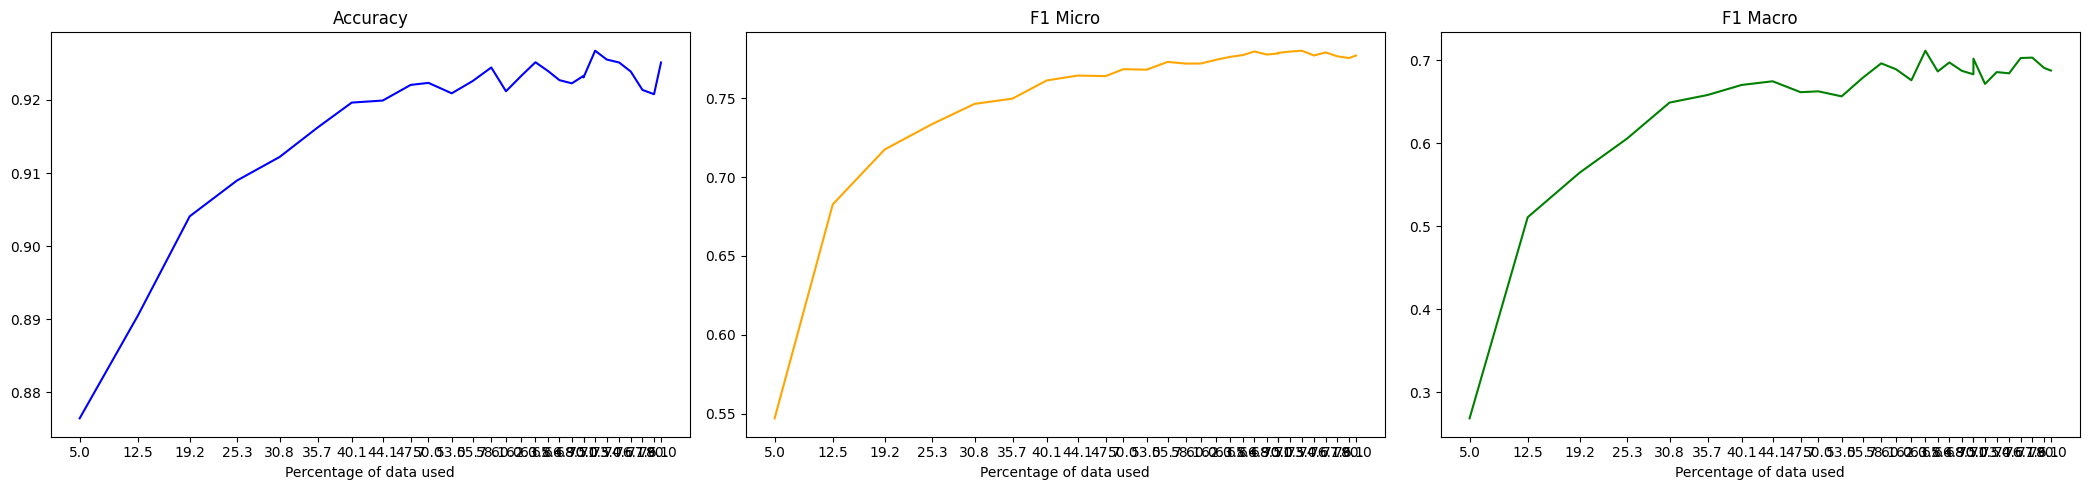

In [19]:
active_learning(seeds[0], 0)